In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import xarray
import seaborn as sns
from scipy import stats

Matplotlib is building the font cache; this may take a moment.


In [2]:
energy = pd.read_csv('Downloads/COONOOER_BRIDGE.csv')
price_data = pd.read_csv('Downloads/VIC_2018.csv')

Coonooer bridge coordinates: 36.4362°S 143.3616°E <br>
Coonooer bridge gridpoints: (19, 22)

In [3]:
energy.iloc[:,0] = pd.to_datetime(energy.iloc[:,0], infer_datetime_format = True)
energy = energy.set_index("Date_Time")
energy_2018 = energy.loc[datetime(2017,12,31,6,0,0):datetime(2018,12,31,5,30,0)]
energy_night = ~((energy.index.hour>=12) & (energy.index.hour<0))

In [4]:
idx1 = pd.DataFrame(pd.date_range(datetime(2017,12,31),datetime(2018,2,28), freq = '5min'))
idx2 = pd.DataFrame(pd.date_range(datetime(2018,12,1),datetime(2018,12,31), freq = '5min'))
pd.concat([idx1,idx2])

,0
0,2017-12-31 00:00:00
1,2017-12-31 00:05:00
2,2017-12-31 00:10:00
3,2017-12-31 00:15:00
4,2017-12-31 00:20:00
...,...
8636,2018-12-30 23:40:00
8637,2018-12-30 23:45:00
8638,2018-12-30 23:50:00
8639,2018-12-30 23:55:00


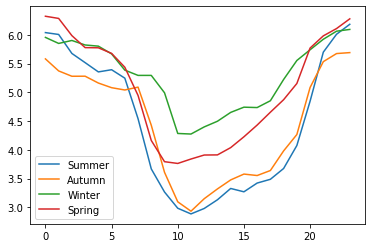

In [60]:
summer = pd.concat([energy_2018.loc
         [datetime(2017,12,31,6,0,0):datetime(2018,3,1)], energy_2018.loc[datetime(2018,12,1):datetime(2018,12,31,5,30)]])
autumn = energy_2018.loc[datetime(2018,3,1):datetime(2018,6,1)]
winter = energy_2018.loc[datetime(2018,6,1):datetime(2018,9,1)]
spring = energy_2018.loc[datetime(2018,9,1):datetime(2018,12,1)]

hourly_summer = summer.groupby(summer.index.hour).mean()
hourly_autumn = autumn.groupby(autumn.index.hour).mean()
hourly_winter = winter.groupby(winter.index.hour).mean()
hourly_spring = spring.groupby(spring.index.hour).mean()

plt.plot(hourly_summer, label = 'Summer')
plt.plot(hourly_autumn, label = 'Autumn')
plt.plot(hourly_winter, label = 'Winter')
plt.plot(hourly_spring, label = 'Spring')
plt.legend()

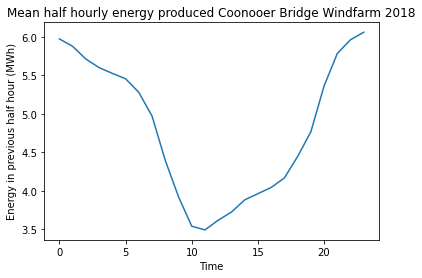

In [61]:
mean_hourly = energy_2018.groupby(energy_2018.index.hour).mean()
plt.plot(mean_hourly)
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Mean half hourly energy produced Coonooer Bridge Windfarm 2018')
plt.savefig('Coonooer half hour energy')

In [5]:
gridpoints = 1
jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv4')
jetnight2 = xarray.DataArray(jetnight.jetnight2_v4, dims = ['time','latitude','longitude'])
jetnight2 = jetnight2.isel(latitude = slice(19-gridpoints,19+gridpoints), longitude = slice(22-gridpoints,22+gridpoints))

# t = np.arange(datetime(2017,12,31), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
# jetnight2['time'] = t
# bool_2018 = jetnight2.time.dt.year == 2018
# jetnight2_2018 = jetnight2[bool_2018]
# jetnight_true = jetnight2_2018.sum(dim = ['latitude', 'longitude']) > 0
# print(jetnight_true.sum().data)

t = np.arange(datetime(2017,12,31,6,0,0), datetime(2018,12,31,6,0,0), timedelta(days=1)).astype(datetime)
jetnight2['time'] = t
jetnight2_2018 = jetnight2
jetnight_true = jetnight2_2018.sum(dim = ['latitude', 'longitude']) > 0
print(jetnight_true.sum().data)

99


In [6]:
# gridpoints = 2
# jetnight = xarray.open_dataset('/g/data/v46/lh2344/jetnightsv2')
# jetnight2 = xarray.DataArray(jetnight.jetnight2_v2, dims = ['time','latitude','longitude'])
# jetnight2 = jetnight2.isel(latitude = slice(19-gridpoints,19+gridpoints), longitude = slice(22-gridpoints,22+gridpoints))

# t = np.arange(datetime(2015,1,1), datetime(2019,1,1), timedelta(days=1)).astype(datetime)
# jetnight2['time'] = t
# bool_2018 = jetnight2.time.dt.year == 2018
# jetnight2_2018 = jetnight2[bool_2018]
# jetnight_true = jetnight2_2018.sum(dim = ['latitude', 'longitude']) > 0
# print(jetnight_true.sum().data)

In [7]:
# On a jetnight an array is created so that every half hour timestep within a jetnight is defined at 'True' and
# 'False' otherwise
jethour_true = np.empty(365*48)
for day in range(0,365):
    daystart = day*48 #Offset by 12 hours (24 half hours) to start at 12pm instead of midnight
    dayend = (day*48)+48 
    for hour in range(daystart,dayend):
        jethour_true[hour] = jetnight_true[day]
jethour_true.sum()
#jethour_true = np.delete(jethour_true,[-1])
jethour_true = np.array(jethour_true, dtype = bool)

In [8]:
days = np.arange(datetime(2017,12,31), datetime(2018,12,31), timedelta(days=1)).astype(datetime)
jetnight_true1 = pd.DataFrame([days,jetnight_true.to_numpy()])#, columns = ['Day','Jetnight?'])
jetnight_truedf = pd.DataFrame(jetnight_true1.T)#, columns = ['Day','Jetnight?'])
#jetnight_truedf = jetnight_truedf.iloc[:,0].reset_index()
jetnight_truedf.rename(columns = {0:"Date", 1: "Jetnight?"})

,Date,Jetnight?
0,2017-12-31,False
1,2018-01-01,True
2,2018-01-02,False
3,2018-01-03,True
4,2018-01-04,True
...,...,...
360,2018-12-26,False
361,2018-12-27,False
362,2018-12-28,True
363,2018-12-29,False


In [9]:
# Time stamp is turned into the index
#energy_2018 = energy_2018.set_index(["Date_Time"])
idx = np.arange(datetime(2017,12,31,6,0,0), datetime(2018,12,31,6,0,0), timedelta(minutes=30)).astype(datetime)

In [10]:
# At midnight the timestamp used in the wind data is 23:59:59, so midnight is moved back 1 second so the data can be
# reindexed
idx1 = np.empty(len(idx), dtype = datetime)
for i in range(len(idx)):
    if idx[i].hour == 0 | idx[i].minute == 0:
        idx1[i] = idx[i] - timedelta(seconds=1)
    else: idx1[i] = idx[i]  

energy_2018 = energy_2018.reindex(idx1)

In [11]:
print(jethour_true.shape)
print(energy_2018.index.shape)

(17520,)
(17520,)


In [12]:
energy_2018_jetnight = energy_2018[jethour_true]
energy_2018_nonjetnight = energy_2018[~jethour_true]
energy_2018_jetnight =  energy_2018_jetnight.reset_index()
energy_2018_nonjetnight =  energy_2018_nonjetnight.reset_index()

In [13]:
energy_2018_jetnight['Date_Time'] = pd.to_datetime(energy_2018_jetnight['Date_Time'])
energy_2018_jetnight['minutes'] = energy_2018_jetnight['Date_Time'].apply(lambda x: x.minute)
energy_2018_jetnight['hour'] = energy_2018_jetnight['Date_Time'].apply(lambda x: x.hour)

energy_2018_nonjetnight['Date_Time'] = pd.to_datetime(energy_2018_nonjetnight['Date_Time'])
energy_2018_nonjetnight['minutes'] = energy_2018_nonjetnight['Date_Time'].apply(lambda x: x.minute)
energy_2018_nonjetnight['hour'] = energy_2018_nonjetnight['Date_Time'].apply(lambda x: x.hour)

In [71]:
halfhour = energy_2018_jetnight.drop(columns = ['Date_Time', 'minutes','hour'])
halfhour = halfhour.to_numpy()
halfhour

array([[3.789758],
       [3.858431],
       [1.886428],
       ...,
       [7.185605],
       [7.600223],
       [6.283243]])

In [72]:
hourly_mean_jetnight = energy_2018_jetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_jetnight['minutes'] = np.arange(0,24,0.5)
hourly_mean_jetnight = hourly_mean_jetnight.drop(columns = ['hour'])

hourly_median_jetnight = energy_2018_jetnight.groupby(['hour', 'minutes']).median().reset_index()
hourly_median_jetnight['minutes'] = np.arange(0,24,0.5)
hourly_median_jetnight = hourly_median_jetnight.drop(columns = ['hour'])

hourly_mean_nonjetnight = energy_2018_nonjetnight.groupby(['hour', 'minutes']).mean().reset_index()
hourly_mean_nonjetnight['minutes'] = np.arange(0,24,0.5)
hourly_mean_nonjetnight = hourly_mean_nonjetnight.drop(columns = ['hour'])

hourly_median_nonjetnight = energy_2018_jetnight.groupby(['hour', 'minutes']).median().reset_index()
hourly_median_nonjetnight['minutes'] = np.arange(0,24,0.5)
hourly_median_nonjetnight = hourly_median_nonjetnight.drop(columns = ['hour'])

In [73]:
energy_2018_jetnight['Half-Hour'] = np.tile(np.arange(0,24,0.5),jetnight_true.sum().data)
energy_2018_jetnight['Mean Electricity'] = np.tile(hourly_mean_jetnight.iloc[:,1], jetnight_true.sum().data)

In [74]:
elecjn_2018 = energy_2018_jetnight.iloc[:,1] # Actual electricity produced at each half hour through 2018
elecnonjn_2018 = energy_2018_nonjetnight.iloc[:,1]

elecjn_2018np = elecjn_2018.to_numpy().reshape(jetnight_true.sum().data,48)
elecnonjn_2018np = elecnonjn_2018.to_numpy().reshape(365-jetnight_true.sum().data,48)

In [75]:
# Filter data using np.isnan
mask = ~np.isnan(elecjn_2018np)
elecjn_filter = [d[m] for d, m in zip(elecjn_2018np.T, mask.T)]
print(np.shape(elecjn_filter))

mask = ~np.isnan(elecnonjn_2018np)
elecnonjn_filter = [d[m] for d, m in zip(elecnonjn_2018np.T, mask.T)]
print(np.shape(elecnonjn_filter))

(48,)
(48,)


/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [77]:
xticks = np.concatenate([np.arange(6,24),np.arange(0,6)])
xticks
time = pd.date_range(datetime(2018,1,1,6,0,0), datetime(2018,1,2,6,0,0), freq = 'H')
time.hour

Int64Index([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
            23,  0,  1,  2,  3,  4,  5,  6],
           dtype='int64')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


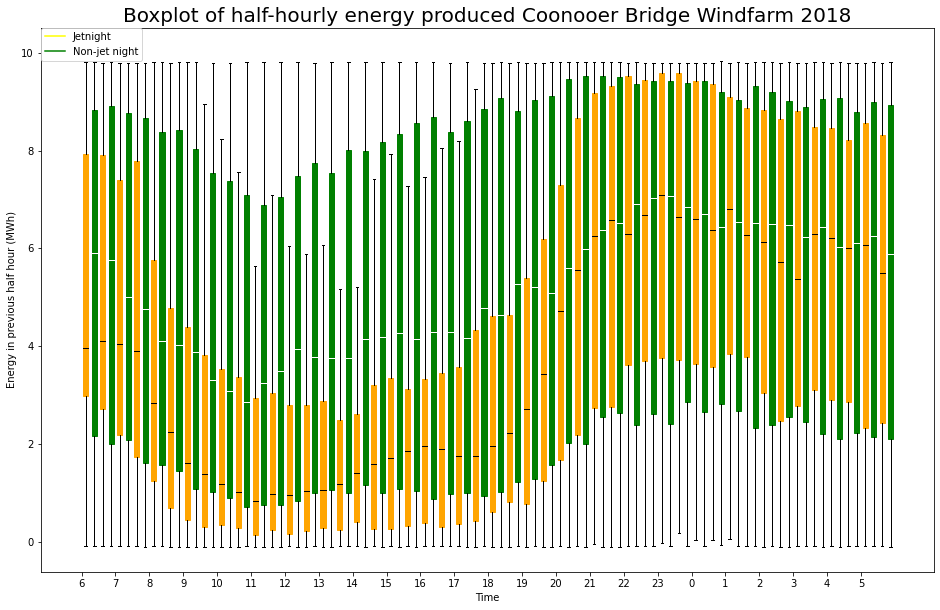

In [80]:
# Filter data using np.isnan
mask = ~np.isnan(elecjn_2018np)
filtered_data = [d[m] for d, m in zip(elecjn_2018np.T, mask.T)]
np.shape(filtered_data)


plt.figure(figsize = (16,10))
plt.boxplot(elecjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.25, 48.25, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='orange', color='orange'),  medianprops=dict(color='black'))
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced Coonooer Bridge Windfarm 2018 (Jetnights)')
#plt.xticks(np.arange(0,50,2), labels = np.arange(0,25,1))
#plt.show()
#plt.savefig('Jetnight energy boxplot')

plt.boxplot(elecnonjn_filter, manage_ticks = False, showfliers = False, 
            positions = np.arange(0.75, 48.75, 1), widths = 0.3, patch_artist = True, 
            boxprops=dict(facecolor='green', color='green'),  medianprops=dict(color='white'))
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Boxplot of half-hourly energy produced Coonooer Bridge Windfarm 2018', fontsize = 20)
#plt.xticks(np.arange(0,50,2), labels = np.arange(0,25,1))
plt.xticks(np.arange(0,48,2), labels = xticks)

hY, = plt.plot([0,1],'yellow')
hG, = plt.plot([0,10],'green')
plt.legend((hY, hG),('Jetnight', 'Non-jet night'), loc = [0,0.94])
hY.set_visible(False)
hG.set_visible(False)

plt.savefig('Non jetnights energy boxplot')

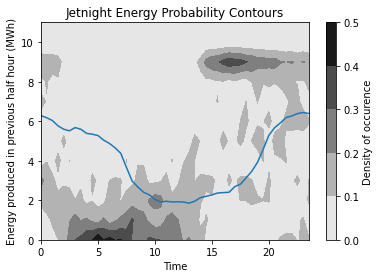

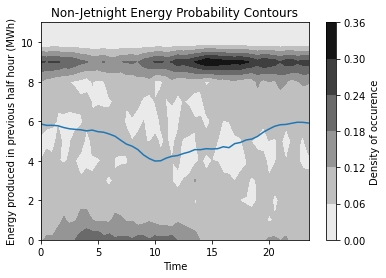

In [23]:
bins = 12 # Highest y-value (energy production)
histjn = np.empty([48,bins])
histnonjn = np.empty([48,bins])


for i in range(0,48): # produces number of values at each energy interval from 1-12
    histjn[i,:],_ = np.histogram(elecjn_2018np[:,i], bins = np.arange(0,bins+1), density = True)
    histnonjn[i,:],_ = np.histogram(elecnonjn_2018np[:,i], bins = np.arange(0,bins+1), density = True)

#hist.T
plt.contourf(np.arange(0,24,0.5), np.arange(0,bins), histjn.T, 5, cmap = 'binary') # histogram transposed so contour function reads it as columns rather than rows
plt.plot(hourly_mean_jetnight.iloc[:,0],hourly_mean_jetnight.iloc[:,1], label = 'Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Jetnight Energy Probability Contours')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()

plt.contourf(np.arange(0,24,0.5), np.arange(0,bins), histnonjn.T, 5, cmap = 'binary')
plt.plot(hourly_mean_nonjetnight.iloc[:,0],hourly_mean_nonjetnight.iloc[:,1], label = 'Non-Jetnight')
plt.colorbar(label = 'Density of occurence')
plt.title('Non-Jetnight Energy Probability Contours')
plt.ylabel('Energy produced in previous half hour (MWh)')
plt.xlabel('Time')
plt.show()


In [24]:
# Double checking contour graph makes sense
density, _ = np.histogram(elecnonjn_2018np[:,47], bins = np.arange(0,12), density = False)
_, values = np.histogram(elecnonjn_2018np[:,47], bins = np.arange(0,12), density = False)
print(density)
print(values)
print(stats.describe(elecnonjn_2018np[:,47]))

[24 24 21 17 13 19 17 17 31 65  0]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
DescribeResult(nobs=266, minmax=(nan, nan), mean=nan, variance=nan, skewness=nan, kurtosis=nan)


In [25]:
from statsmodels.stats.weightstats import ztest as ztest

z_score = np.empty(48)
p_value = np.empty(48)
for i in range(0,48):
    filtjn, filtnonjn = ~np.isnan(elecjn_2018np[:,i]), ~np.isnan(elecnonjn_2018np[:,i]) # removes nans before passing through significance test
    z_score[i], p_value[i] = ztest(elecjn_2018np[:,i][filtjn], elecnonjn_2018np[:,i][filtnonjn], value = 0)


significant = p_value < 0.05
significant

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

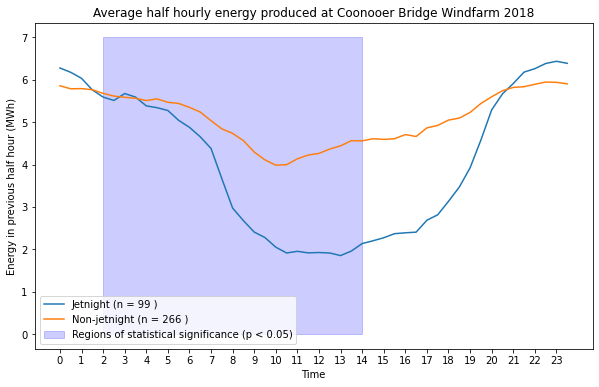

In [26]:
plt.figure(figsize = [10,6])
plt.plot(hourly_mean_jetnight.iloc[:,0],hourly_mean_jetnight.iloc[:,1], label = 'Jetnight (n = '+ str(jetnight_true.sum().data)+' )')
plt.plot(hourly_mean_nonjetnight.iloc[:,0],hourly_mean_nonjetnight.iloc[:,1], label = 'Non-jetnight (n = '+ str(365-jetnight_true.sum().data)+' )')
plt.xlabel('Time')
plt.ylabel('Energy in previous half hour (MWh)')
plt.title('Average half hourly energy produced at Coonooer Bridge Windfarm 2018')
plt.xticks(np.arange(0,24))
plt.fill_between(np.arange(0,24,0.5),0,7, where = significant,
                 facecolor="blue", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2, label = 'Regions of statistical significance (p < 0.05)')   

plt.legend()
plt.savefig('Coonooer Bridge power jetnights (mean)')

In [27]:
# Find percentage ramping events
percent_ramp = np.empty(len(energy_2018)-1)
energy_2018_np = energy_2018.to_numpy()
for i in range(0,len(energy_2018)-1):
    if energy_2018_np[i] <= 0:
        percent_ramp[i] = np.nan
    else: percent_ramp[i] = ((energy_2018.iloc[i+1] - energy_2018.iloc[i]) / energy_2018.iloc[i]) * 100

In [28]:
energy_2018_np.shape

(17520, 1)

In [29]:
start = datetime(2017,12,31,6,30,0)
end = datetime(2018,12,31,5,30,0)

percent_ramp_time = xarray.DataArray(percent_ramp, coords = {"time": pd.date_range(start,end, freq = "30min")})
percent_ramp_time_morning = xarray.DataArray(
    np.empty(len(percent_ramp)), coords = {"time": pd.date_range(start,end, freq = "30min")})

for i in range(len(percent_ramp_time)):
    if 17 <= percent_ramp_time[i].time.dt.hour <= 21:
        percent_ramp_time_morning[i] = percent_ramp_time[i]
    
    else: percent_ramp_time_morning[i] = np.nan

In [30]:
pd.date_range(datetime(2018,1,1), datetime(2018,12,31), freq = 'M').strftime("%B")

Index(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December'],
      dtype='object')

([<matplotlib.axis.XTick at 0x7f5d21037760>,
 [Text(1, 0, 'January'),
  Text(2, 0, 'February'),
  Text(3, 0, 'March'),
  Text(4, 0, 'April'),
  Text(5, 0, 'May'),
  Text(6, 0, 'June'),
  Text(7, 0, 'July'),
  Text(8, 0, 'August'),
  Text(9, 0, 'September'),
  Text(10, 0, 'October'),
  Text(11, 0, 'November'),
  Text(12, 0, 'December')])

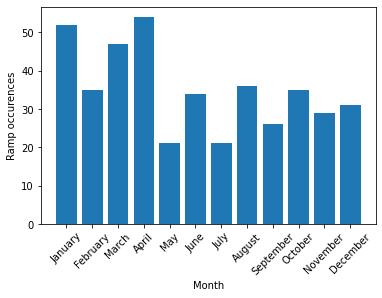

In [31]:
ramp = percent_ramp_time_morning > 50
ramps_by_month = ramp.groupby(ramp.time.dt.month).sum()

plt.bar(ramps_by_month.month, ramps_by_month)
plt.xlabel('Month')
plt.ylabel('Ramp occurences')
plt.xticks(ramps_by_month.month, pd.date_range(datetime(2018,1,1), datetime(2018,12,31), freq = 'M').strftime("%B"), rotation = 45)

In [32]:
jethour_true1 = np.delete(jethour_true, 0) # delete midnight on first day
jetnight_ramps = percent_ramp_time_morning[jethour_true1]
nonjetnight_ramps = percent_ramp_time_morning[~jethour_true1]

In [33]:
energy_2018.index = energy_2018.index.rename('time')
energy_2018xr = xarray.DataArray(energy_2018.iloc[:,0], coords = {"time": energy_2018.index})

jn_ramp_percent = np.empty(20)
nonjn_ramp_percent = np.empty(20)
for index, i in enumerate(np.arange(10,210,10)):
    high_rampjn = jetnight_ramps > i
    high_rampnonjn = nonjetnight_ramps > i
    ramp_datejn = energy_2018xr.sel(time = slice(start, end)).where(high_rampjn).dropna(dim = 'time').time.dt.date
    ramp_datenonjn = energy_2018xr.sel(time = slice(start, end)).where(high_rampnonjn).dropna(dim = 'time').time.dt.date
    jn_ramp_percent[index] = ( len(np.unique(np.array(ramp_datejn))) / jetnight_true.sum() ) * 100
    nonjn_ramp_percent[index] = ( len(np.unique(np.array(ramp_datenonjn))) / (~jetnight_true).sum() ) * 100

In [34]:
high_rampjn = jetnight_ramps > 50
high_rampnonjn = nonjetnight_ramps > 50
ramp_datejn = energy_2018xr.sel(time = slice(start, end)).where(high_rampjn).dropna(dim = 'time').time.dt.date
ramp_datenonjn = energy_2018xr.sel(time = slice(start, end)).where(high_rampnonjn).dropna(dim = 'time').time.dt.date
ramp_datejn
len(np.unique(np.array(ramp_datenonjn)))

120

In [35]:
# ramp_monthjn = high_rampjn.groupby(high_rampjn.time.dt.month).sum()
# ramp_monthnonjn = high_rampnonjn.groupby(high_rampnonjn.time.dt.month).sum()

# plt.bar(np.arange(-0.2,11.8),  ramp_monthjn,width = 0.3, label = 'Jetnight (n = '+ str(jetnight_true.sum().data) +')')
# plt.bar(np.arange(0.1,12.1),  ramp_monthnonjn, width = 0.3, label = 'Non jetnight (n = '+ str(365-jetnight_true.sum().data) +')')
# plt.title('Evening ramping occurences > 50% occuring \non jet nights versus non jet nights (Loosened criteria)')
# plt.xticks(np.arange(0,12), pd.date_range(datetime(2018,1,1), datetime(2018,12,31), freq = 'M').strftime("%B"), rotation = 45)
# plt.xlabel('Month')
# plt.ylabel('Number of ramping occurences')

# plt.legend()

In [36]:
# print('% of summer ramps occuring on jet nights',(ramp_monthjn[0:2].sum() + ramp_monthjn[11])*100 / (ramps_by_month[0:2].sum() + ramps_by_month[11]))
# print('% of summer ramps occuring on jet nights',(ramp_monthjn[0:3].sum())*100 / (ramps_by_month[0:3].sum()))

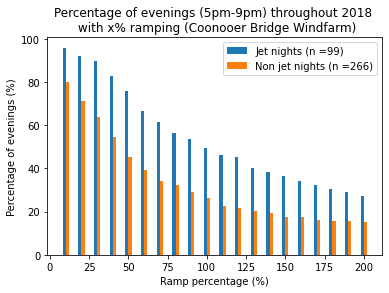

In [37]:
plt.bar(np.arange(9,209,10), jn_ramp_percent, width = 2, label = 'Jet nights (n ='+ str(jetnight_true.sum().data) +')')
plt.bar(np.arange(11,211,10), nonjn_ramp_percent, width = 2, label = 'Non jet nights (n =' + str(365-jetnight_true.sum().data) +')')
plt.title('Percentage of evenings (5pm-9pm) throughout 2018 \n with x% ramping (Coonooer Bridge Windfarm)')
plt.ylabel('Percentage of evenings (%)')
plt.xlabel('Ramp percentage (%)')
plt.legend()
plt.savefig('percent evening ramps')

In [38]:
# print('Jetnight ramp percent:', len((np.unique(np.array(ramp_datejn))/jetnight_true.sum())*100))
# print('Non jet night ramp percent: ', len((np.unique(np.array(ramp_datenonjn))/(~jetnight_true).sum())*100))

/local/v46/lh2344/tmp/ipykernel_2677496/10186482.py:14: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=24)


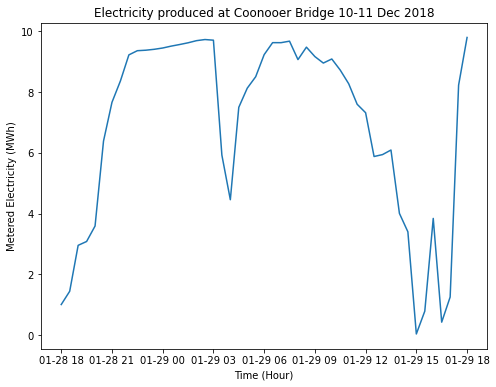

In [39]:
start = datetime(2018,1,28,18,0,0)
end = datetime(2018,1,29,18,0,0)
time_slice = slice(start, end)

plt.figure(figsize = (8,6))
x_ticks = np.concatenate([np.arange(12,24), np.arange(0,12)])
ramp = energy_2018xr.sel(time = time_slice)
#plt.plot(pd.date_range(start, end, freq = '30Min').strftime("%H:%M"), ramp)
plt.plot(ramp.time, ramp)
plt.xlabel('Time (Hour)')
plt.ylabel('Metered Electricity (MWh)')
#plt.xticks(pd.date_range(start, end, freq = '30Min').hour)
#plt.xticks(pd.date_range(start, end, freq = '30Min'), pd.date_range(start, end, freq = '30Min').hour)
plt.locator_params(axis='x', nbins=24)
plt.title('Electricity produced at Coonooer Bridge 10-11 Dec 2018')
plt.savefig('Energy profile 10 Dec')

In [40]:
print('jethour_true length', len(jethour_true))
print('percent_ramp length', len(percent_ramp))
print('jethour_true1 length', len(jethour_true1))

jethour_true length 17520
percent_ramp length 17519
jethour_true1 length 17519


In [41]:
# Checking for statisticss regarding proportion of large rampings in jetnights vs non jetnights
jetnight_20, _ = np.histogram(abs(jetnight_ramps), bins = np.arange(0,140,20)) # In 20% intervals
nonjetnight_20, _ = np.histogram(abs(nonjetnight_ramps), bins = np.arange(0,140,20))
n = 2
jetnight_20[n:].sum()/(jetnight_20[n:].sum() + nonjetnight_20[n:].sum())


0.3400735294117647

### Price Data

In [14]:
price_data

,SETTLEMENTDATE,TOTALDEMAND,DEMAND_AND_NONSCHEDGEN,RRP
0,2018-01-01 00:30:00,4251.18,4400.52,92.46
1,2018-01-01 01:00:00,4092.53,4234.92,87.62
2,2018-01-01 01:30:00,3958.95,4114.49,73.08
3,2018-01-01 02:00:00,3785.27,3958.73,70.18
4,2018-01-01 02:30:00,3673.72,3838.04,67.43
...,...,...,...,...
17515,2018-12-31 22:00:00,4292.49,4387.18,79.39
17516,2018-12-31 22:30:00,4257.85,4348.01,77.34
17517,2018-12-31 23:00:00,4247.55,4317.64,78.95
17518,2018-12-31 23:30:00,4439.96,4508.97,75.33


In [15]:
price_data.iloc[:,0] = pd.to_datetime(price_data.iloc[:,0], infer_datetime_format = True)
price = price_data.set_index('SETTLEMENTDATE').iloc[:,2]
demand = price_data.set_index('SETTLEMENTDATE').iloc[:,0]
energy_2018 = energy_2018.reindex(pd.date_range(start=datetime(2017,12,31,6,0),end = datetime(2018,12,31,5,30,0), 
                    freq = '30Min'))

In [16]:
energy_2018.index.time[1] == datetime(2018,12,1,6,30,0).time
datetime(2018,12,1,6,30,0).minute
energy_2018.index[1] + timedelta(seconds=1)

Timestamp('2017-12-31 06:30:01', freq='30T')

In [17]:
energy_2018 = energy_2018.reset_index()

for i in range(0,len(energy_2018)):
    
    if energy_2018.iloc[i,0].minute == 59:
        energy_2018.iloc[i,0] = energy_2018.iloc[i,0] + timedelta(seconds=1)
    else: energy_2018.iloc[i,0] = energy_2018.iloc[i,0]
energy_2018 = energy_2018.set_index('index')


In [18]:
energy_2018

,Metered Electricity (MWh)
index,
2017-12-31 06:00:00,2.235373
2017-12-31 06:30:00,0.945456
2017-12-31 07:00:00,0.032772
2017-12-31 07:30:00,-0.099929
2017-12-31 08:00:00,-0.096672
...,...
2018-12-31 03:30:00,3.237567
2018-12-31 04:00:00,3.154153
2018-12-31 04:30:00,3.671249


In [19]:
pd.date_range(datetime(2018,1,1,0,0),datetime(2018,12,31,23,30), freq = '30min').difference(energy_2018.index)

DatetimeIndex(['2018-12-31 06:00:00', '2018-12-31 06:30:00',
               '2018-12-31 07:00:00', '2018-12-31 07:30:00',
               '2018-12-31 08:00:00', '2018-12-31 08:30:00',
               '2018-12-31 09:00:00', '2018-12-31 09:30:00',
               '2018-12-31 10:00:00', '2018-12-31 10:30:00',
               '2018-12-31 11:00:00', '2018-12-31 11:30:00',
               '2018-12-31 12:00:00', '2018-12-31 12:30:00',
               '2018-12-31 13:00:00', '2018-12-31 13:30:00',
               '2018-12-31 14:00:00', '2018-12-31 14:30:00',
               '2018-12-31 15:00:00', '2018-12-31 15:30:00',
               '2018-12-31 16:00:00', '2018-12-31 16:30:00',
               '2018-12-31 17:00:00', '2018-12-31 17:30:00',
               '2018-12-31 18:00:00', '2018-12-31 18:30:00',
               '2018-12-31 19:00:00', '2018-12-31 19:30:00',
               '2018-12-31 20:00:00', '2018-12-31 20:30:00',
               '2018-12-31 21:00:00', '2018-12-31 21:30:00',
               '2018-12-

In [20]:
jethour_truedf = pd.DataFrame(jethour_true[37:], index =  pd.date_range(datetime(2018,1,1,0,30),datetime(2018,12,31,5,30), freq = '30min'),
            columns = ['Jethour_true'])

In [21]:
energy_2018

,Metered Electricity (MWh)
index,
2017-12-31 06:00:00,2.235373
2017-12-31 06:30:00,0.945456
2017-12-31 07:00:00,0.032772
2017-12-31 07:30:00,-0.099929
2017-12-31 08:00:00,-0.096672
...,...
2018-12-31 03:30:00,3.237567
2018-12-31 04:00:00,3.154153
2018-12-31 04:30:00,3.671249


In [22]:
price_reindexed = price.reindex(energy_2018.index).dropna()
energy_reindexed = energy_2018.reindex(price.index).dropna()
demand_reindexed = demand.reindex(energy_2018.index).dropna()
jethour_reindexed = jethour_truedf.reindex(energy_2018.index).dropna()
nonjethour_reindexed = (~jethour_truedf).reindex(energy_2018.index).dropna()

# create $300 spot market price cap
for i in range(len(price_reindexed)):
    if price_reindexed[i] > 300:
        price_reindexed[i] = 300
        

revenue = price_reindexed * energy_reindexed.iloc[:,0] # $/MWh * MWh
revenue = revenue.to_frame()
revenue['time'] = revenue.index
revenue['hour'] = revenue.time.dt.hour
revenue['minute'] = revenue.time.dt.minute
jetnight_revenue = revenue[jethour_reindexed.iloc[:,0]] #remove 6:00 31-12 to 00:00 1-1 (37 half hours)
nonjetnight_revenue = revenue[nonjethour_reindexed.iloc[:,0]]

price_df = price_reindexed.to_frame()
price_df['time'] = price_df.index
price_df['hour'] = price_df.time.dt.hour
price_df['minute'] = price_df.time.dt.minute

jetnight_price =price_df[jethour_reindexed.iloc[:,0]] #remove 6:00 31-12 to 00:00 1-1 (37 half hours)
nonjetnight_price = price_df[nonjethour_reindexed.iloc[:,0]]

energy_2018['time'] = energy_2018.index
energy_2018['hour'] = energy_2018.time.dt.hour
energy_2018['minute'] = energy_2018.time.dt.minute

jetnight_energy = energy_2018[37:][jethour_reindexed.iloc[:,0]]
nonjetnight_energy = energy_2018[37:][nonjethour_reindexed.iloc[:,0]]


# sum(output * price) / sum(output) (MWh * $)/MWh = $

In [23]:
print('energy len', len(energy_2018[37:]))
print('price len', len(price_reindexed))
print('revenue len', len(revenue))
print('jet hour len', len(jethour_true[37:]))


energy len 17483
price len 17483
revenue len 17483
jet hour len 17483


In [24]:
# jetnight_revenue.iloc[:,0].resample('D', offset = '6Hour').sum()
# energy_jetnight.iloc[:,0].resample('D', offset = '6Hour').sum()
#jetnight_revenue  =jetnight_revenue.drop(columns = ['time'])

jetnight_hourly_revenue_sum = jetnight_revenue.groupby(['hour','minute']).sum()
nonjetnight_hourly_revenue_sum = nonjetnight_revenue.groupby(['hour','minute']).sum()

jetnight_hourly_price_sum = jetnight_price.groupby(['hour','minute']).sum()
nonjetnight_hourly_price_sum = nonjetnight_price.groupby(['hour','minute']).sum()

jetnight_hourly_energy_sum = jetnight_energy.groupby(['hour','minute']).sum()
nonjetnight_hourly_energy_sum = nonjetnight_energy.groupby(['hour','minute']).sum()

weighted_price_jetnight = jetnight_hourly_revenue_sum.iloc[:,0] / jetnight_hourly_energy_sum.iloc[:,0]
weighted_price_nonjetnight = nonjetnight_hourly_revenue_sum.iloc[:,0] / nonjetnight_hourly_energy_sum.iloc[:,0]
# ($/MWh)*MWh/MWh = $/MWh

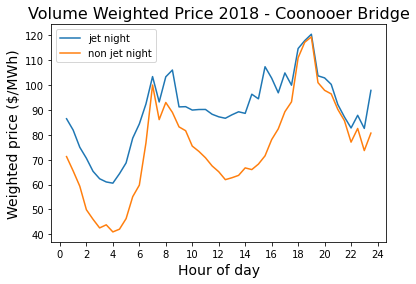

In [25]:
plt.plot(np.arange(0,24,0.5), np.array(weighted_price_jetnight), label = 'jet night')
plt.plot(np.arange(0,24,0.5), np.array(weighted_price_nonjetnight), label = 'non jet night')
plt.ylabel('Weighted price ($/MWh)', fontsize = 14)
plt.xlabel('Hour of day', fontsize = 14)
plt.title('Volume Weighted Price 2018 - Coonooer Bridge', fontsize = 16)

plt.locator_params(axis = 'x',nbins=24)
plt.legend()

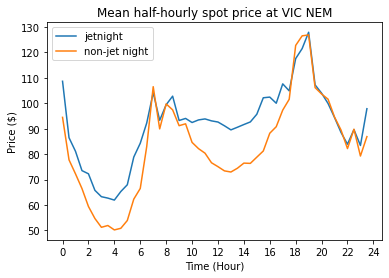

In [26]:
jetnight_hourly_price = jetnight_price.groupby(['hour','minute']).mean()
nonjetnight_hourly_price = nonjetnight_price.groupby(['hour','minute']).mean()
all_price = price_df.groupby(['hour','minute']).mean()

plt.plot(np.arange(0,24,0.5), jetnight_hourly_price, label = 'jetnight')
plt.plot(np.arange(0,24,0.5), nonjetnight_hourly_price, label = 'non-jet night')
#plt.plot(np.arange(0,24,0.5), all_price, label = 'all nights')
plt.title('Mean half-hourly spot price at VIC NEM')
plt.xlabel('Time (Hour)')
plt.ylabel('Price ($)')
plt.locator_params(axis = 'x',nbins=24)

plt.legend()

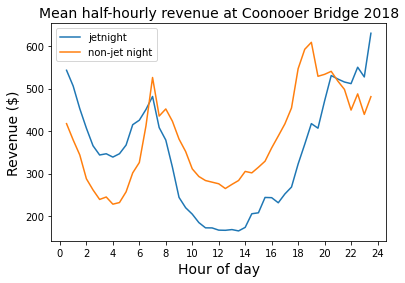

In [27]:
jetnight_hourly_revenue = jetnight_revenue.groupby(['hour','minute']).mean()
nonjetnight_hourly_revenue = nonjetnight_revenue.groupby(['hour','minute']).mean()
all_revenue = revenue.groupby(['hour','minute']).mean()

plt.plot(np.arange(0,24,0.5), jetnight_hourly_revenue, label = 'jetnight')
plt.plot(np.arange(0,24,0.5), nonjetnight_hourly_revenue, label = 'non-jet night')
#plt.plot(np.arange(0,24,0.5), all_revenue, label = 'all nights')
plt.title('Mean half-hourly revenue at Coonooer Bridge 2018', fontsize = 14)
plt.xlabel('Hour of day', fontsize = 14)
plt.ylabel('Revenue ($)', fontsize = 14)
plt.locator_params(axis = 'x',nbins=24)

plt.legend()

In [90]:
jetnight_hourly_revenue[0:12].sum()+jetnight_hourly_revenue[40:48].sum()
#nonjetnight_hourly_revenue[12:40].sum()

0    8688.252385
dtype: float64

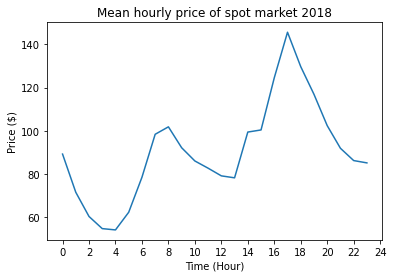

In [66]:
hourly_price = price.groupby(price.index.hour).mean()
plt.plot(hourly_price)
plt.title('Mean hourly price of spot market 2018')
plt.xlabel('Time (Hour)')
plt.ylabel('Price ($)')
plt.locator_params(axis = 'x',nbins=24)

In [91]:
demand

SETTLEMENTDATE
2018-01-01 00:30:00    4251.18
2018-01-01 01:00:00    4092.53
2018-01-01 01:30:00    3958.95
2018-01-01 02:00:00    3785.27
2018-01-01 02:30:00    3673.72
                        ...   
2018-12-31 22:00:00    4292.49
2018-12-31 22:30:00    4257.85
2018-12-31 23:00:00    4247.55
2018-12-31 23:30:00    4439.96
2019-01-01 00:00:00    4486.20
Name: TOTALDEMAND, Length: 17520, dtype: float64

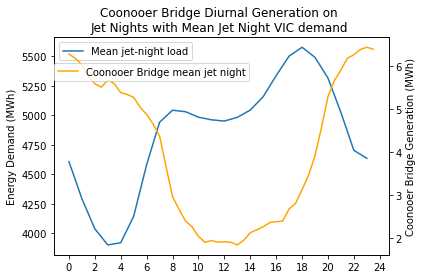

In [112]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

hourly_demand = demand_reindexed[jethour_true[37:]].groupby(demand_reindexed[jethour_true[37:]].index.hour).mean()
ax1.plot(np.arange(0,24),hourly_demand, label = 'Mean jet-night load')
ax2.plot(hourly_mean_jetnight.iloc[:,0],hourly_mean_jetnight.iloc[:,1], 
         label = 'Coonooer Bridge mean jet night', color = 'orange')
ax1.legend()
ax2.legend(loc = [0,0.8])
ax1.set_ylabel('Energy Demand (MWh)')
ax2.set_ylabel('Coonooer Bridge Generation (MWh)')
ax2.set_xlabel('Time (Hour)')
ax2.set_title('Coonooer Bridge Diurnal Generation on \nJet Nights with Mean Jet Night VIC demand ')
plt.locator_params(axis = 'x',nbins=24)

Text(0.5, 1.0, 'VIC Demand by Season')

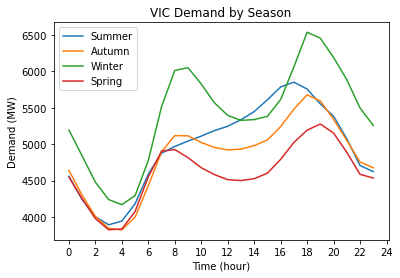

In [72]:
summer = pd.concat([demand.loc
         [datetime(2018,1,1,0,30,0):datetime(2018,3,1)], demand.loc[datetime(2018,12,1):datetime(2018,12,31,5,30)]])
autumn = demand.loc[datetime(2018,3,1):datetime(2018,6,1)]
winter = demand.loc[datetime(2018,6,1):datetime(2018,9,1)]
spring = demand.loc[datetime(2018,9,1):datetime(2018,12,1)]

hourly_summer = summer.groupby(summer.index.hour).mean()
hourly_autumn = autumn.groupby(autumn.index.hour).mean()
hourly_winter = winter.groupby(winter.index.hour).mean()
hourly_spring = spring.groupby(spring.index.hour).mean()

plt.plot(hourly_summer, label = 'Summer')
plt.plot(hourly_autumn, label = 'Autumn')
plt.plot(hourly_winter, label = 'Winter')
plt.plot(hourly_spring, label = 'Spring')

plt.ylabel('Demand (MW)')
plt.xlabel('Time (hour)')
plt.locator_params(axis = 'x',nbins=24)
plt.legend()
plt.title('VIC Demand by Season')

Text(0.5, 1.0, 'Spot Price by Season')

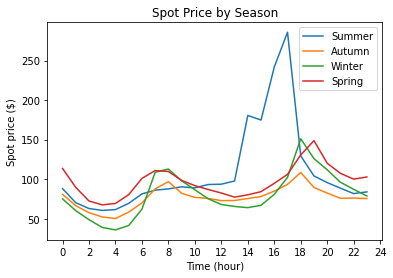

In [28]:
summer = pd.concat([price.loc
         [datetime(2018,1,1,0,30,0):datetime(2018,3,1)], price.loc[datetime(2018,12,1):datetime(2018,12,31,5,30)]])
autumn = price.loc[datetime(2018,3,1):datetime(2018,6,1)]
winter = price.loc[datetime(2018,6,1):datetime(2018,9,1)]
spring = price.loc[datetime(2018,9,1):datetime(2018,12,1)]

hourly_summer = summer.groupby(summer.index.hour).mean()
hourly_autumn = autumn.groupby(autumn.index.hour).mean()
hourly_winter = winter.groupby(winter.index.hour).mean()
hourly_spring = spring.groupby(spring.index.hour).mean()

plt.plot(hourly_summer, label = 'Summer')
plt.plot(hourly_autumn, label = 'Autumn')
plt.plot(hourly_winter, label = 'Winter')
plt.plot(hourly_spring, label = 'Spring')

plt.ylabel('Spot price ($)')
plt.xlabel('Time (hour)')
plt.locator_params(axis = 'x',nbins=24)
plt.legend()
plt.title('Spot Price by Season')

Text(0.5, 1.0, 'Coonooer Bridge Hourly Revenue by Season')

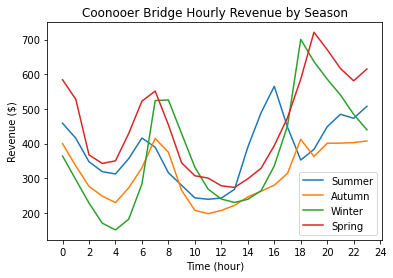

In [54]:
summer = pd.concat([revenue.iloc[:,0].loc
         [datetime(2018,1,1,0,30,0):datetime(2018,3,1)], revenue.iloc[:,0].loc[datetime(2018,12,1):datetime(2018,12,31,5,30)]])
autumn = revenue.iloc[:,0].loc[datetime(2018,3,1):datetime(2018,6,1)]
winter = revenue.iloc[:,0].loc[datetime(2018,6,1):datetime(2018,9,1)]
spring = revenue.iloc[:,0].loc[datetime(2018,9,1):datetime(2018,12,1)]

hourly_summer = summer.groupby(summer.index.hour).mean()
hourly_autumn = autumn.groupby(autumn.index.hour).mean()
hourly_winter = winter.groupby(winter.index.hour).mean()
hourly_spring = spring.groupby(spring.index.hour).mean()

plt.plot(hourly_summer, label = 'Summer')
plt.plot(hourly_autumn, label = 'Autumn')
plt.plot(hourly_winter, label = 'Winter')
plt.plot(hourly_spring, label = 'Spring')

plt.ylabel('Revenue ($)')
plt.xlabel('Time (hour)')
plt.locator_params(axis = 'x',nbins=24)

plt.legend()
plt.title('Coonooer Bridge Hourly Revenue by Season')